In [1]:
import os
import pathlib

In [2]:
import os
import sys
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from models.research.object_detection.utils import label_map_util
from models.research.object_detection.utils import visualization_utils as vis_util
import random

%matplotlib inline

In [3]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [4]:
## Test model
# PATH_TO_GRAPH = r'models/rcnn_resnet101/frozen_inference_graph.pb'
# PATH_TO_GRAPH = r'models/rcnn/frozen_inference_graph.pb'
PATH_TO_GRAPH = r'F:/Object Detection/Traffic_light_detection/ssd_inception_v2_graph/sim/frozen_inference_graph.pb' ## load SSD trained on udacity's parking lot images
PATH_TO_LABELS = r'F:/Object Detection/Traffic_light_detection/data/udacity_label_map.pbtxt'
NUM_CLASSES = 4

In [5]:
detection_graph = load_graph(PATH_TO_GRAPH)

In [6]:
category_index = {1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}

In [7]:
IMAGE_SIZE = (12, 8)

SCORES
[9.9935961e-01 9.9796236e-01 6.2615162e-01 9.8994374e-04 4.6497583e-04
 3.5825372e-04 3.5697222e-04 3.4737587e-04 3.4457445e-04 3.3983588e-04]
CLASSES
[1. 1. 1. 2. 1. 4. 4. 2. 1. 3.]


SCORES
[9.9960464e-01 9.9484485e-01 9.9293709e-01 1.3498366e-03 6.7317486e-04
 4.6840310e-04 4.3061376e-04 3.7103891e-04 3.3402443e-04 3.1128526e-04]
CLASSES
[1. 1. 1. 2. 2. 3. 2. 2. 3. 2.]


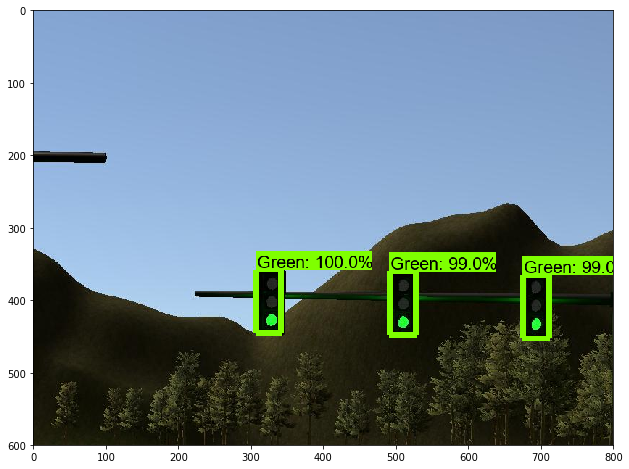

SCORES
[9.9986666e-01 9.9945706e-01 8.7032592e-01 1.1698306e-02 9.9611282e-03
 4.4758618e-03 2.4874806e-03 1.3760626e-03 8.4182620e-04 4.3043494e-04]
CLASSES
[2. 2. 2. 2. 2. 1. 3. 3. 2. 1.]


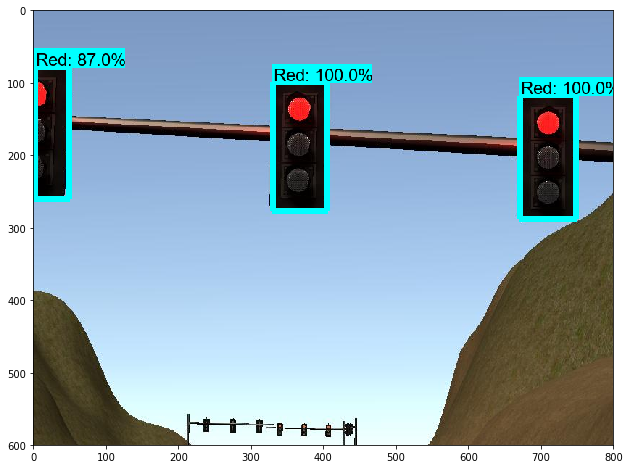

SCORES
[9.9935961e-01 9.9796236e-01 6.2615162e-01 9.8994374e-04 4.6497583e-04
 3.5825372e-04 3.5697222e-04 3.4737587e-04 3.4457445e-04 3.3983588e-04]
CLASSES
[1. 1. 1. 2. 1. 4. 4. 2. 1. 3.]


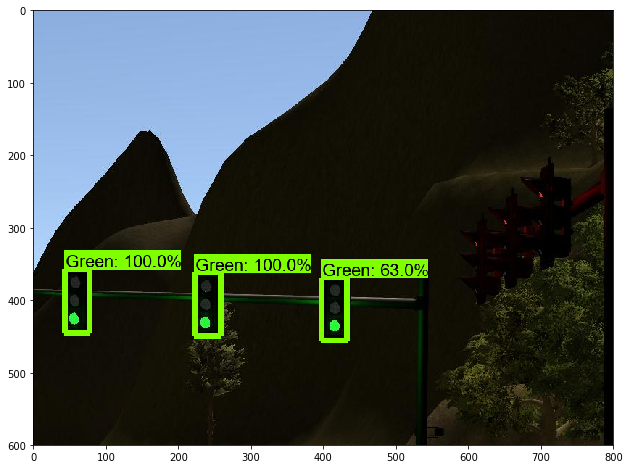

SCORES
[9.9972296e-01 9.9961662e-01 9.9895370e-01 8.4161758e-04 4.7430396e-04
 4.3863058e-04 3.8704276e-04 3.2258034e-04 3.1173229e-04 3.0723214e-04]
CLASSES
[1. 1. 1. 2. 2. 3. 2. 2. 2. 2.]


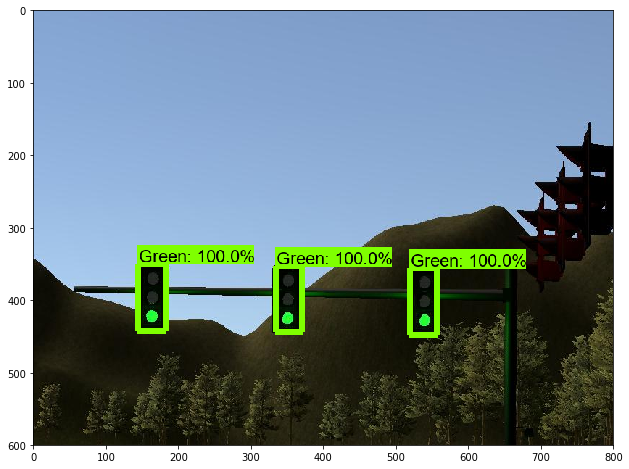

SCORES
[6.3217789e-01 5.3993541e-01 1.0735512e-02 1.5717745e-03 9.2986226e-04
 8.2361698e-04 5.1438808e-04 4.1580200e-04 4.0233135e-04 3.7604570e-04]
CLASSES
[2. 2. 2. 1. 1. 2. 2. 2. 4. 3.]


SCORES
[9.9960464e-01 9.9484485e-01 9.9293709e-01 1.3498366e-03 6.7317486e-04
 4.6840310e-04 4.3061376e-04 3.7103891e-04 3.3402443e-04 3.1128526e-04]
CLASSES
[1. 1. 1. 2. 2. 3. 2. 2. 3. 2.]


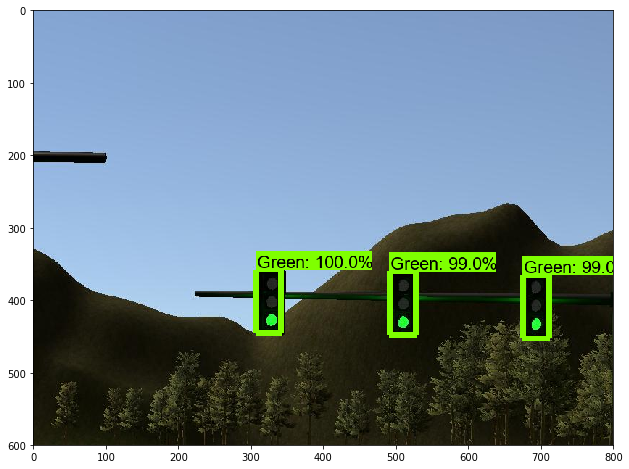

SCORES
[9.9935961e-01 9.9796236e-01 6.2615162e-01 9.8994374e-04 4.6497583e-04
 3.5825372e-04 3.5697222e-04 3.4737587e-04 3.4457445e-04 3.3983588e-04]
CLASSES
[1. 1. 1. 2. 1. 4. 4. 2. 1. 3.]


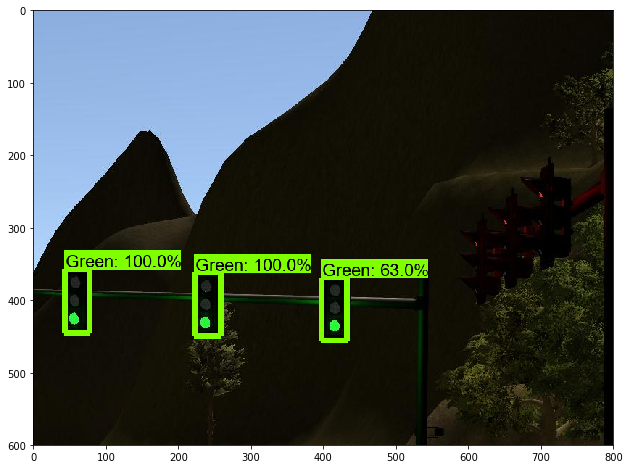

SCORES
[9.9972296e-01 9.9961662e-01 9.9895370e-01 8.4161758e-04 4.7430396e-04
 4.3863058e-04 3.8704276e-04 3.2258034e-04 3.1173229e-04 3.0723214e-04]
CLASSES
[1. 1. 1. 2. 2. 3. 2. 2. 2. 2.]


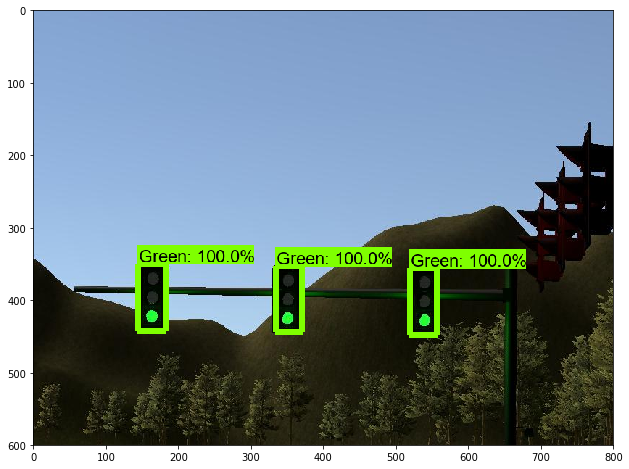

SCORES
[9.9934375e-01 9.9839431e-01 9.6751940e-01 1.5815198e-03 1.3257563e-03
 1.1211038e-03 5.2693486e-04 4.8983097e-04 4.0462613e-04 3.6296248e-04]
CLASSES
[3. 3. 3. 3. 3. 3. 3. 2. 4. 2.]


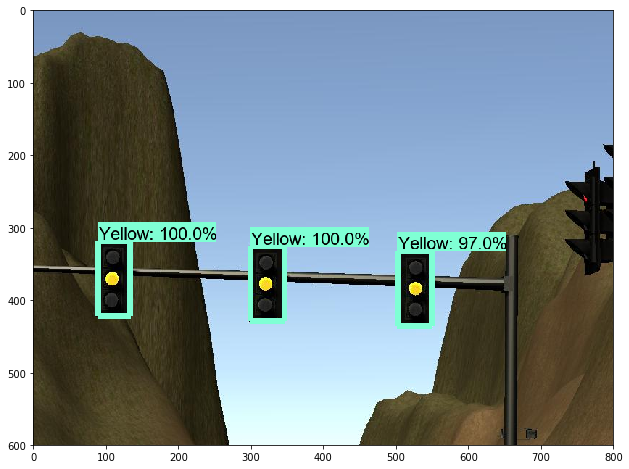

SCORES
[6.3217789e-01 5.3993541e-01 1.0735512e-02 1.5717745e-03 9.2986226e-04
 8.2361698e-04 5.1438808e-04 4.1580200e-04 4.0233135e-04 3.7604570e-04]
CLASSES
[2. 2. 2. 1. 1. 2. 2. 2. 4. 3.]


In [8]:
PATH_TO_IMGS = r'test_images'
TEST_IMGS = glob(os.path.join(PATH_TO_IMGS, r'*.png'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            random.shuffle(TEST_IMGS)
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break

In [9]:
PATH_TO_GRAPH = r'F:/Object Detection/Traffic_light_detection/ssd_inception_v2_graph/real/frozen_inference_graph.pb' ## load SSD trained on udacity's simulator images
detection_graph = load_graph(PATH_TO_GRAPH)

SCORES
[9.9987125e-01 2.2268295e-04 2.1839142e-04 1.9440055e-04 1.9431114e-04
 1.9225478e-04 1.9222498e-04 1.8081069e-04 1.6948581e-04 1.5240908e-04]
CLASSES
[2. 3. 1. 2. 4. 1. 2. 2. 1. 4.]


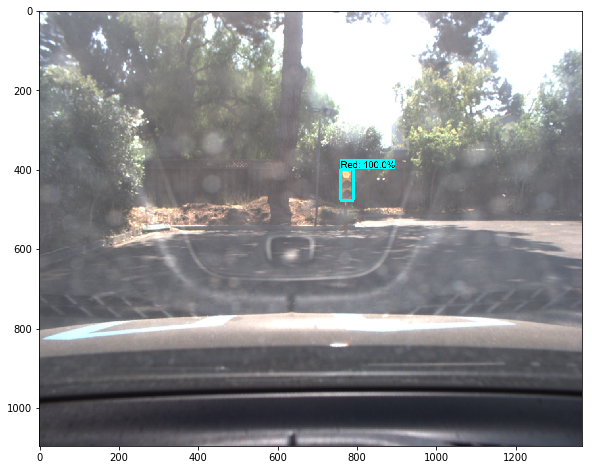

SCORES
[9.9987125e-01 2.2268295e-04 2.1839142e-04 1.9440055e-04 1.9431114e-04
 1.9225478e-04 1.9222498e-04 1.8081069e-04 1.6948581e-04 1.5240908e-04]
CLASSES
[2. 3. 1. 2. 4. 1. 2. 2. 1. 4.]


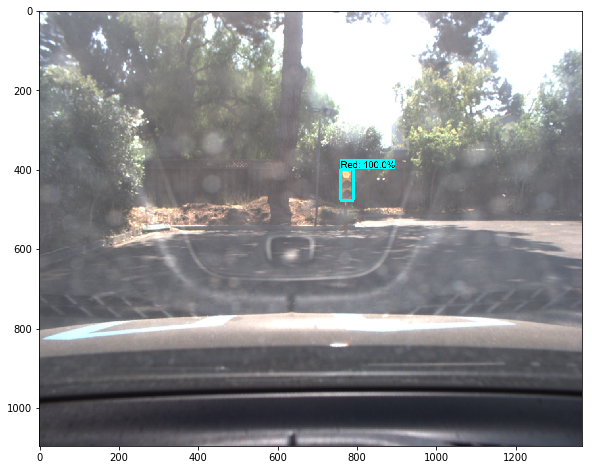

SCORES
[9.9987125e-01 2.2268295e-04 2.1839142e-04 1.9440055e-04 1.9431114e-04
 1.9225478e-04 1.9222498e-04 1.8081069e-04 1.6948581e-04 1.5240908e-04]
CLASSES
[2. 3. 1. 2. 4. 1. 2. 2. 1. 4.]


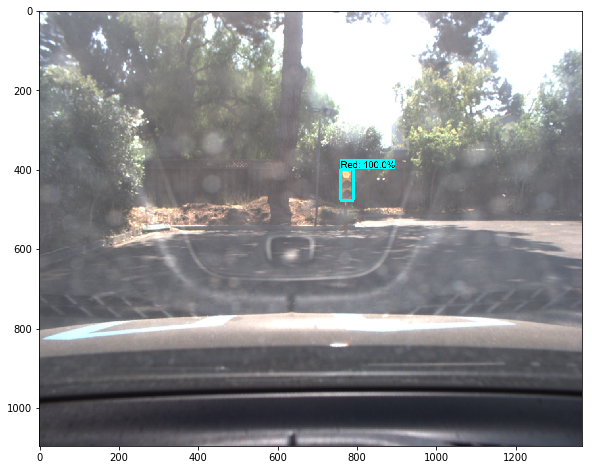

In [12]:
PATH_TO_IMGS = r'test_images'
TEST_IMGS = glob(os.path.join(PATH_TO_IMGS, r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            random.shuffle(TEST_IMGS)
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break